In [1]:
# Running on GPU?

import setGPU

setGPU: Setting GPU to: 0


In [2]:
import math
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.models import Model, load_model
from keras import backend as K
from keras import regularizers

from scipy import misc

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

Using TensorFlow backend.


# Regional approach to Drift Tubes Digi Occupancy Anomaly Problem

* [Load data](#Load-occupancy-data-to-the-dataframe)
* [Preprocessing](#Preprocessing)
    * [Visualizing preprocessing](#Visualize-preprocessing-steps)
* [Anomaly detection](#Searching-for-anomalies)
    * [Append labels](#Append-labels)
    * [Production baseline](#Production-baseline)
    * [Local model baseline](#Local-model-baseline)
    * [Examples of faults](#Examples-of-voltage-fault)
    * [Neural networks](#Benchmarking-neural-networks)
    * [Data snooping](#Data-snooping)
    * [Evaluation](#Evaluation)
* [Global approach](#Global-approach-to-Drift-Tubes-Digi-Occupancy-Anomaly-Problem)

In [3]:
# Load models from disk

LOAD_MODELS = True

In [4]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 18
matplotlib.rcParams["ytick.labelsize"] = 18
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [5]:
# Set data directory
# You can copy the data from /eos/cms/store/cmst3/group/dehep/adpol/dt/data

data_directory = "../data"
keras_model = "../models-local/cnn.h5"
models_directory = "../models-regional-global"
figure_export_directory = "../figures"

## Load occupancy data to the dataframe

In [6]:
# Load occupancy data to the dataframe

runs = [272011, 272012, 272014, 272017, 272021, 272774, 273158, 273730,
        274388, 274422, 274968, 274969, 275310, 275311, 275847, 275890,
        276244, 276283, 276384, 276582, 276587, 276775, 276776, 276950,
        278509, 278820, 278822, 279694, 279766, 279794, 280018, 281693,
        281727, 281976, 282735, 282814, 284041, 284042, 284043, 284044,
        297411, 297467, 297468, 297469, 297484, 297665, 297666, 297678,
        299000, 300087, 300390, 300391, 300392, 300393, 300395, 300396,
        300397, 300398, 300399, 300497, 300558, 301142, 301383, 301384,
        302031, 302038, 302040, 302041, 302042, 302043, 302350, 302548,
        302634, 302635, 304144, 304737, 304738, 304739, 304740, 305064,
        305081, 306041, 306042, 306049]

test_run = [302634, 302635, 304737, 304738, 304739, 304740]
train_runs = [r for r in runs if r not in test_run]

drift_tubes_layers = pd.DataFrame()
for run in runs:
    print("Loading %s" % run, end="\r")
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);
print("Done. Collected %s layers" % drift_tubes_layers.shape[0], end="\r")

In [7]:
# Filter out all runs having less than 50 lumisections worth of statistics

drift_tubes_layers = drift_tubes_layers.query("lumi%400>50")

In [8]:
# Filter out all chambers in MB4

drift_tubes_layers = drift_tubes_layers.query("station<4")

In [9]:
# Transform the string of hits to list

drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(np.array)

## Preprocessing

In [10]:
# Use median polling to remove channels with extreme values (smoothing)

SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

In [11]:
# Use linear interpolation to resize all the data samples (standardization)

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))

def resize_occupancy(layer):
    """Resizes occupancy to a given size using bilinear interpolation"""
    return misc.imresize(np.array(layer).reshape(1, -1), (1, SAMPLE_SIZE), interp="bilinear", mode="F").reshape(-1)

drift_tubes_layers["content_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

In [12]:
# Evaluate if the layer is faulty using pretrained CNN model.

CNN_MODEL = load_model(keras_model)
SAMPLE_SIZE = 47

def scale_occupancy(layer):
    """Scales the layer to the <0, 1> range"""
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

def score_occupancy(layer):
    """Predicts if layer is faulty or good"""
    layer = resize_occupancy(layer)
    layer = scale_occupancy(layer)
    return np.argmax(CNN_MODEL.predict(layer.reshape(-1, 47)))

drift_tubes_layers["score"] = drift_tubes_layers["content"].apply(score_occupancy)

In [13]:
# Combine per layer data to per chamber data

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 4):
            for sector in range(1, 13):

                chamber = drift_tubes_layers[
                    (drift_tubes_layers.run == run) &
                    (drift_tubes_layers.wheel == wheel) &
                    (drift_tubes_layers.station == station) &
                    (drift_tubes_layers.sector == sector)].sort_values("layer",
                                                                       ascending=1)
                if not len(chamber):
                    continue

                occupancy_resized = np.concatenate(
                    chamber["content_resized"].values).reshape(-1, SAMPLE_SIZE)

                occupancy_raw = [layer.tolist() for layer in chamber["content"]]
                occupancy_smoothed = [layer.tolist() for layer in chamber["content_smoothed"]]
                
                extended_size_raw = max((len(_) for _ in occupancy_raw))
                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))

                for index, layer in enumerate(occupancy_raw):
                    layer.extend([np.nan]*(extended_size_raw-len(layer)))
                    occupancy_raw[index] = layer

                for index, layer in enumerate(occupancy_smoothed):
                    layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                    occupancy_smoothed[index] = layer
                   
                score = sum(chamber.score.values)

                data = {"run": run,
                        "wheel": wheel,
                        "station": station,
                        "sector": sector,
                        "score": score,
                        "content_resized": occupancy_resized,
                        "content_smoothed": np.reshape(occupancy_smoothed,
                                                       (len(chamber), extended_size_smoothed)),
                        "content_raw": np.reshape(occupancy_raw,
                                                  (len(chamber), extended_size_raw))}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data),
                                                                   ignore_index=True)

In [14]:
# Normalize the data (normalization)

def scale_chamber(hits_array):
    """Sales hits by a given scaler."""
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(hits_array.reshape(-1, 1))
    return pd.Series({"content_resized": scaler.transform(hits_array.reshape(-1, 1)).reshape(-1, SAMPLE_SIZE)})

def scale_dataset(new_column, old_column):
    """Scales the dataset"""
    drift_tubes_chambers[new_column] = drift_tubes_chambers.apply(lambda row: scale_chamber(row[old_column]),
                                                                  axis=1)
scale_dataset("content_scaled", "content_resized")

### Visualize preprocessing steps

In [15]:
def plot_occupancy_hitmap(data, title, save_name, unit):
    """Visualizes occupancy hitmap"""
    fig, ax = plt.subplots()
    
    ax = plt.gca()
    
    ax.set_xlim([-2, np.array(data).shape[1]+1])
    ax.set_yticklabels(["1", "5", "9"])
    ax.set_yticks([0, 4, 8])
    ax.set_ylim([13,-2])

    plt.xlabel("Channel", horizontalalignment='right', x=1.0)
    plt.ylabel("Layer", horizontalalignment='right', y=1.0)
    
    # Deal with .eps export
    masked_array = np.ma.array (data, mask=np.isnan(data))
    cmap = matplotlib.cm.viridis
    cmap.set_bad("white", 1.)
    
    im = ax.imshow(data, interpolation="nearest", cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    if unit == "a.u.":
        form = '%.2f'
    else:
        form = '%.0f'
    
    plt.colorbar(im,
                 cax=cax,
                 format=form,
                 ticks=[np.min(np.nan_to_num(data)),
                        np.max(np.nan_to_num(data))])
    
    plt.title(title, loc="right")   
    
    ax.text(1.1, 0.75, unit, rotation=90,
        verticalalignment="top", horizontalalignment="right",
        transform=ax.transAxes, color="black", fontsize=16)
    
    ax.text(0, 1.16, "CMS", weight='bold',
        verticalalignment="top", horizontalalignment="left",
        transform=ax.transAxes, color="black", fontsize=18)

    if save_name:
        fig.savefig("%s/occupancy%s.eps" % (figure_export_directory,
                                           save_name),
                    bbox_inches="tight")
    plt.show();
    
def get_title(title, show):
    """Generates title for occupancy plot"""
    return ("%sRun: %s, W: %s, St: %s, Sec: %s" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show):
    plot_occupancy_hitmap(show.content_raw,
                          get_title("Raw Occupancy, ", show),
                          False,
                          "counts")
    plot_occupancy_hitmap(show.content_smoothed,
                          get_title("Smoothed Occupancy, ", show),
                          False,
                          "a.u.")
    plot_occupancy_hitmap(show.content_resized,
                          get_title("Standardized Occupancy, ", show),
                          False,
                          "a.u.")
    plot_occupancy_hitmap(show.content_scaled,
                          get_title("Scaled Occupancy, ", show),
                          False,
                          "a.u.") 

Example of preprocessing pipeline for <b>chamber without problems</b>:

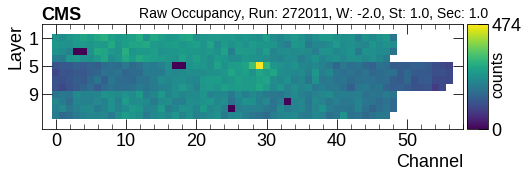

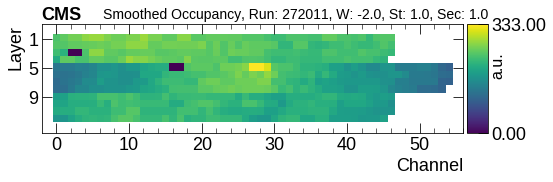

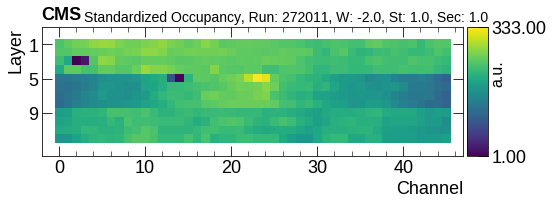

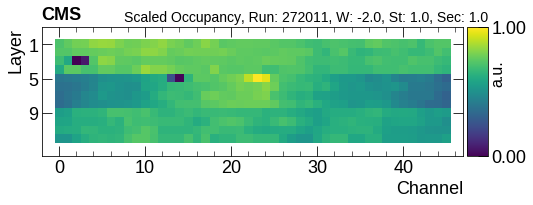

In [16]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[0])

Example of preprocessing pipeline for <b>chamber with problems</b>:

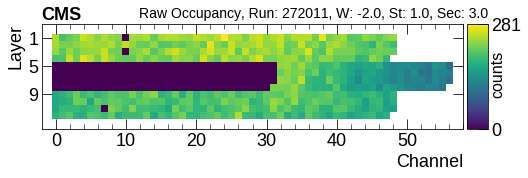

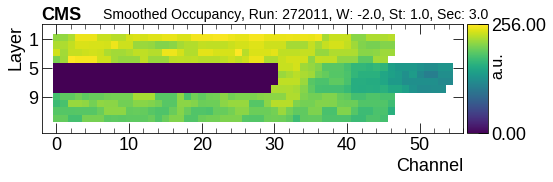

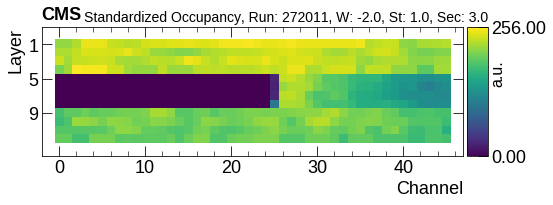

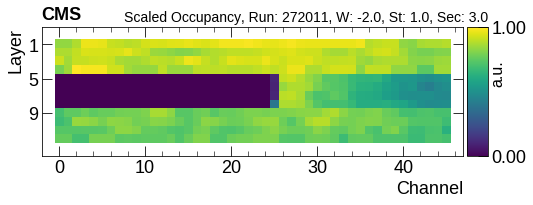

In [17]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score > 0].iloc[0])

## Searching for anomalies

### Append labels

<b>Run 302635</b>: OK for the collected data<br>
<b>Run 302634</b>: MB4 and MB1 in S3-S4-S5 of WP2, WM2 and W00 have the correct HV<br>
<b>Run 302634</b>: All the other chambers in layer 9 operate at 3200V (almost off)<br>
<b>Runs 304737, 304738, 304739, 304740</b>: All the chambers in layer 9 operate at 3450V (hit efficiency ~70%)

In [18]:
# Add HV information to the layer dataframe

drift_tubes_layers.loc[:, "voltage_fault"] = np.nan

# 302634, 304737, 304738, 304739, 304740
drift_tubes_layers.loc[drift_tubes_layers["run"].isin([302634, 304737, 304738, 304739, 304740]),
                       "voltage_fault"] = 1

# 302635
drift_tubes_layers.loc[(drift_tubes_layers["run"] == 302635),  "voltage_fault"] = -1

# 302634
drift_tubes_layers.loc[(drift_tubes_layers["run"] == 302634) &
                       (drift_tubes_layers["station"].isin([1, 4])) &
                       (drift_tubes_layers["sector"].isin([3, 4, 5])) &
                       (drift_tubes_layers["wheel"].isin([-2, 0, 2])), "voltage_fault"] = -1

# If not layer 9
drift_tubes_layers.loc[(drift_tubes_layers["layer"] != 9), "voltage_fault"] = -1

In [19]:
# Add HV information to the chamber dataframe

drift_tubes_chambers.loc[:, "voltage_fault"] = np.nan

# 302634, 304737, 304738, 304739, 304740
drift_tubes_chambers.loc[drift_tubes_chambers["run"].isin([302634, 304737, 304738, 304739, 304740]),
                         "voltage_fault"] = 1

# 302635
drift_tubes_chambers.loc[drift_tubes_chambers["run"] == 302635,  "voltage_fault"] = -1

# 302634
drift_tubes_chambers.loc[(drift_tubes_chambers["run"] == 302634) &
                         (drift_tubes_chambers["station"].isin([1, 4])) &
                         (drift_tubes_chambers["sector"].isin([3, 4, 5])) &
                         (drift_tubes_chambers["wheel"].isin([-2, 0, 2])), "voltage_fault"] = -1

In [20]:
# Combine score of CNN model and voltage fault

drift_tubes_chambers["combined_score"] = ((drift_tubes_chambers["voltage_fault"] == 1) | 
                                          (drift_tubes_chambers["score"] > 0))*2-1

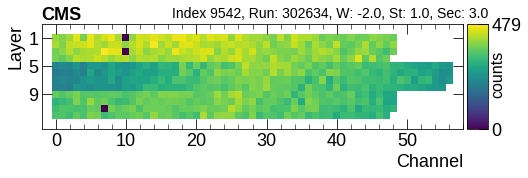

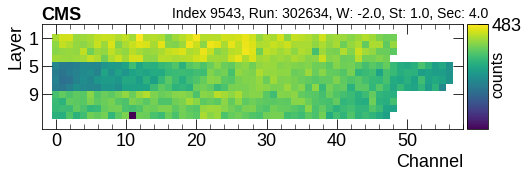

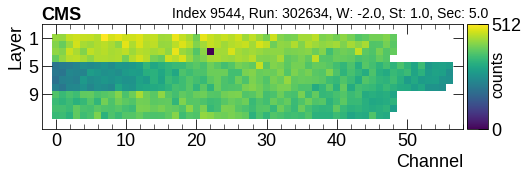

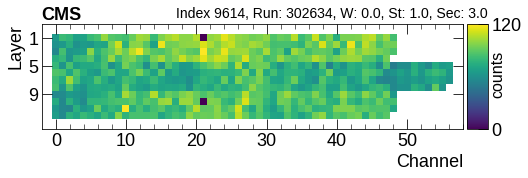

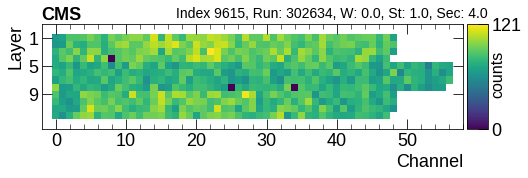

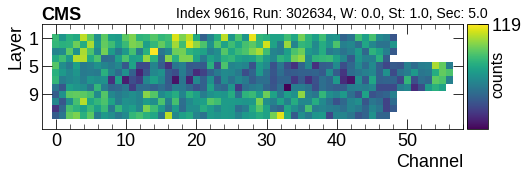

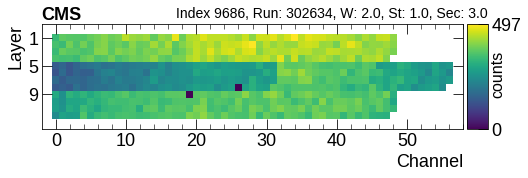

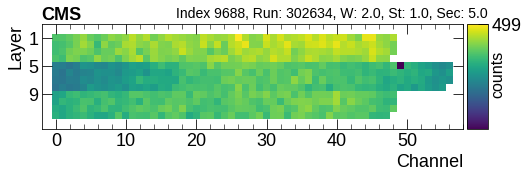

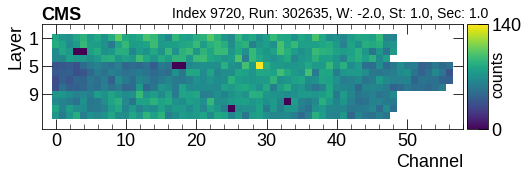

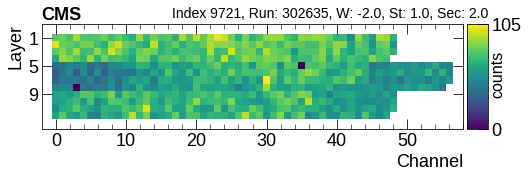

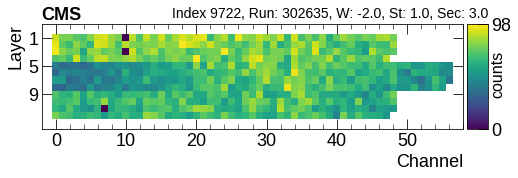

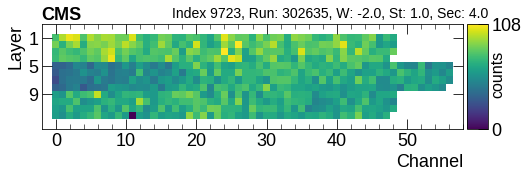

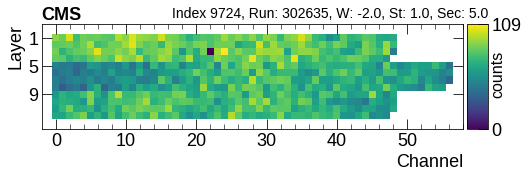

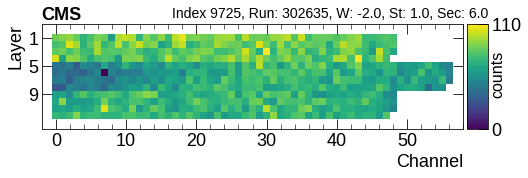

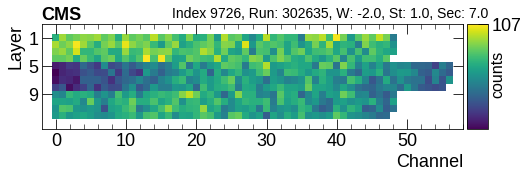

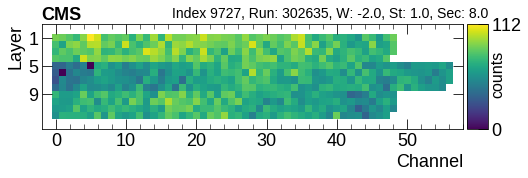

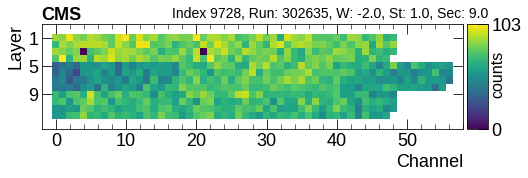

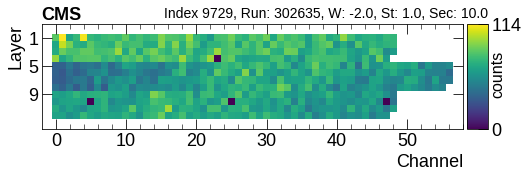

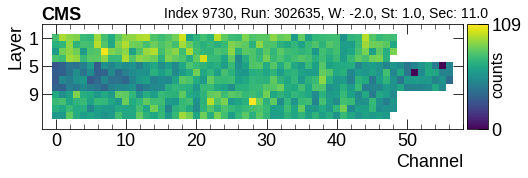

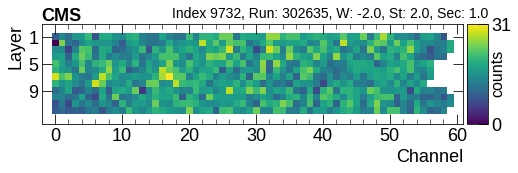

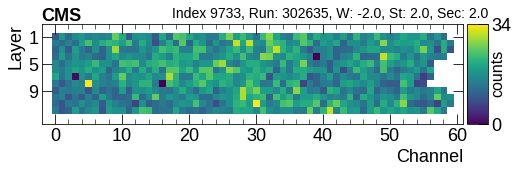

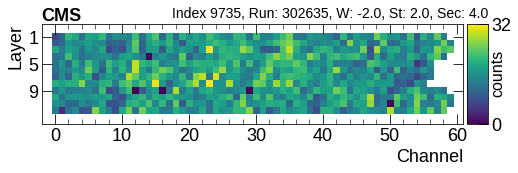

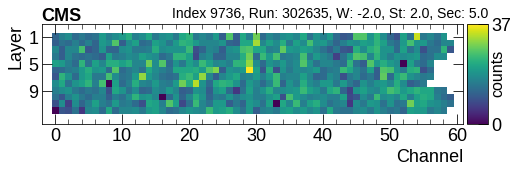

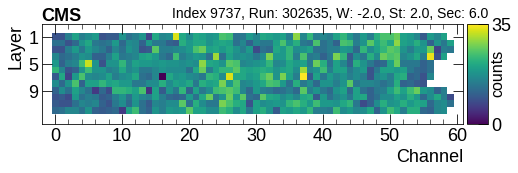

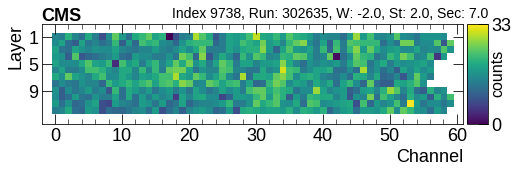

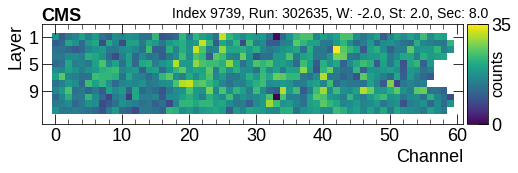

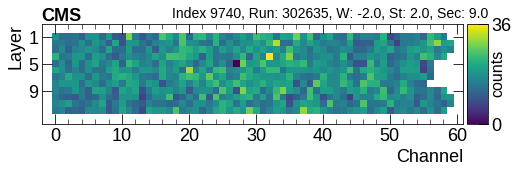

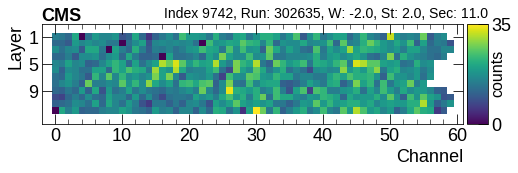

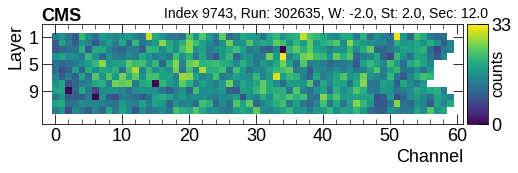

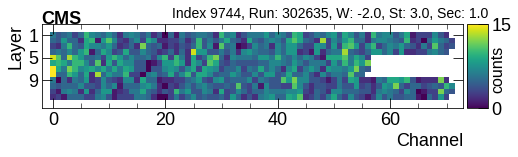

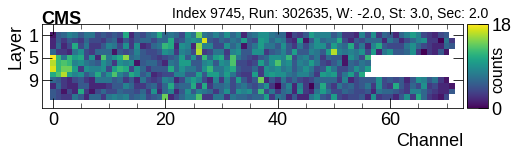

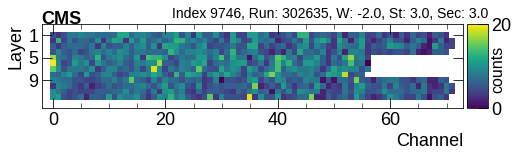

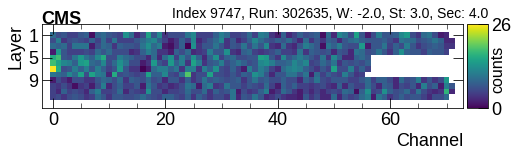

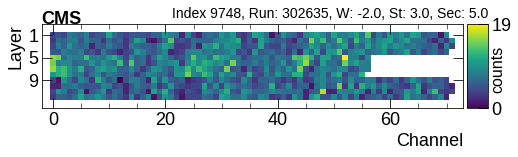

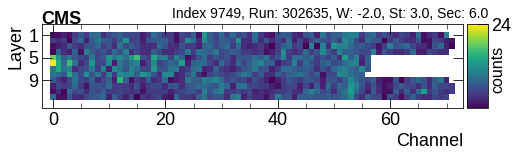

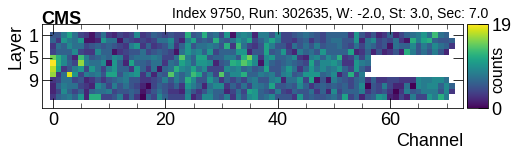

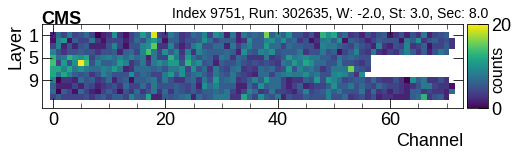

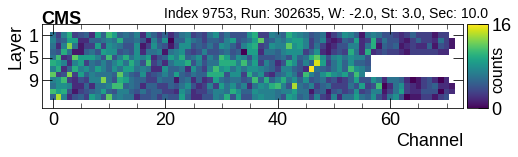

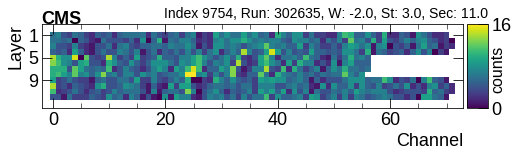

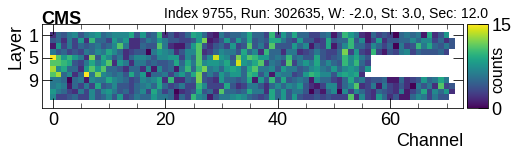

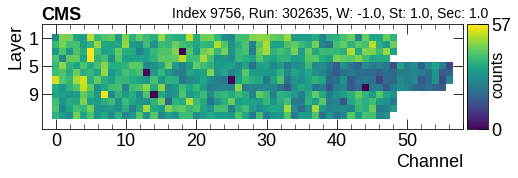

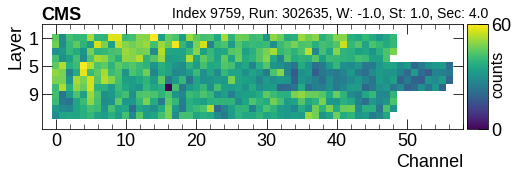

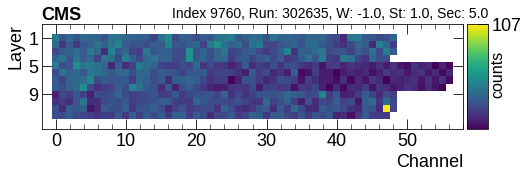

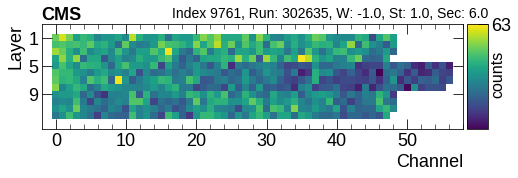

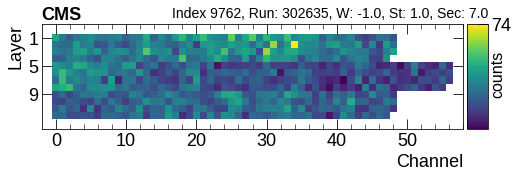

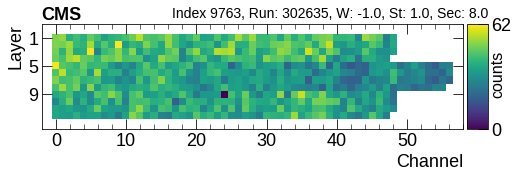

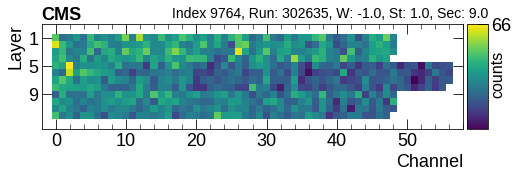

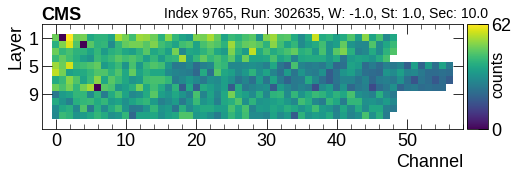

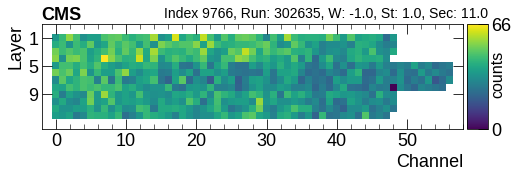

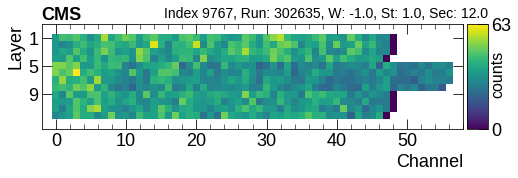

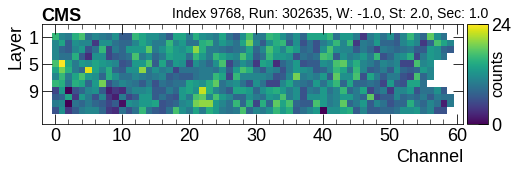

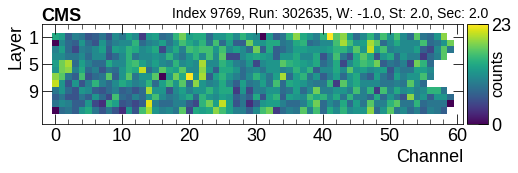

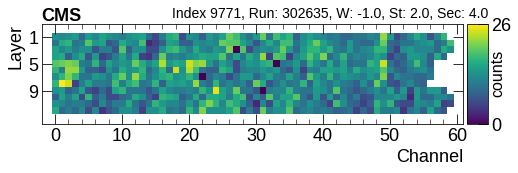

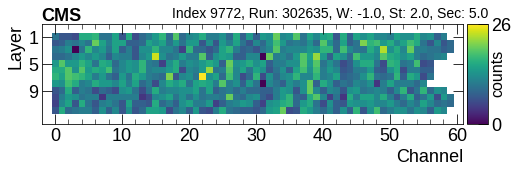

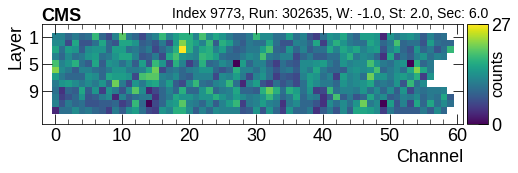

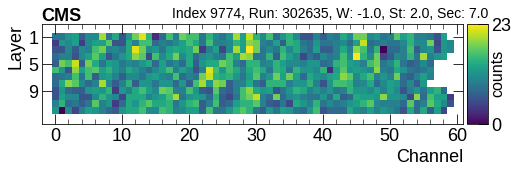

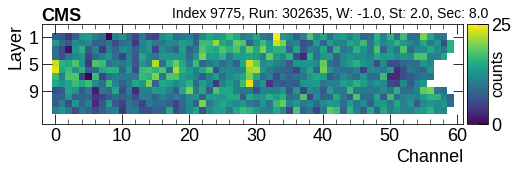

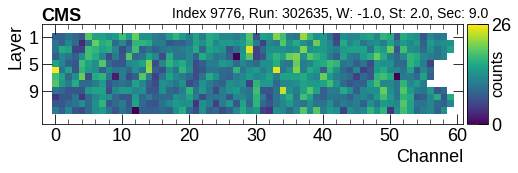

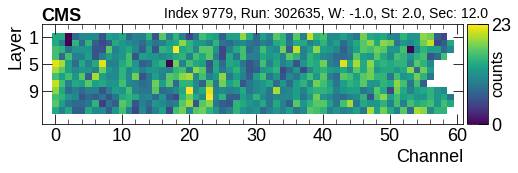

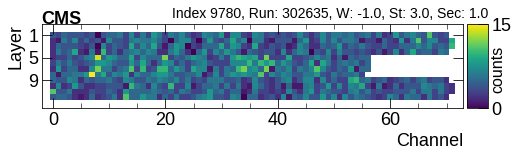

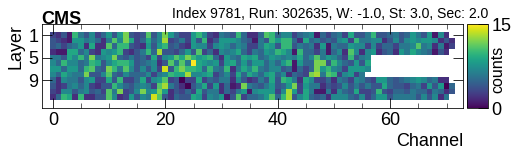

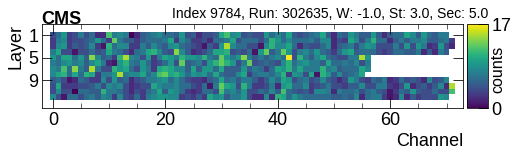

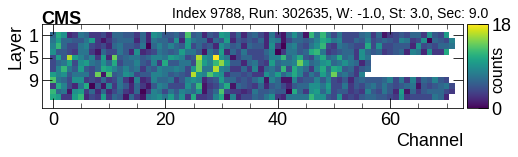

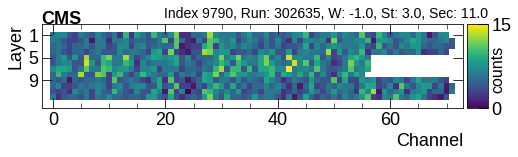

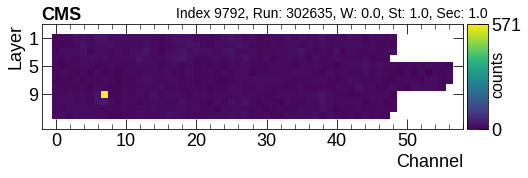

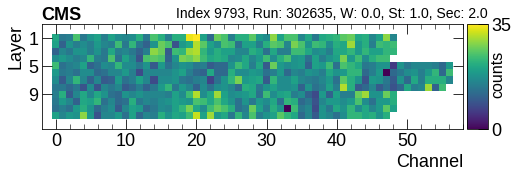

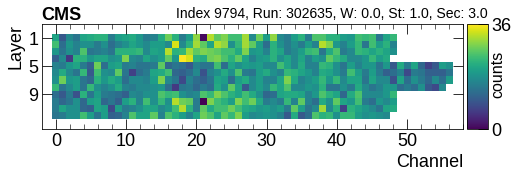

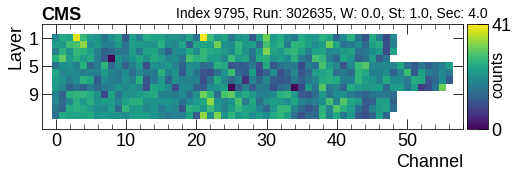

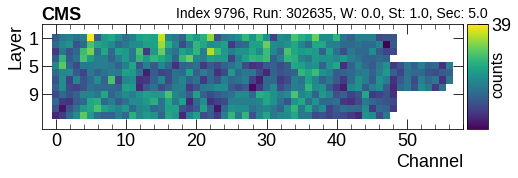

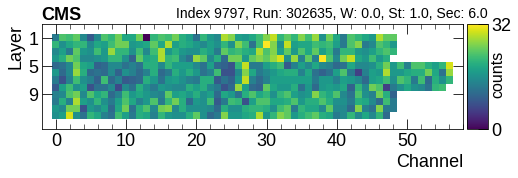

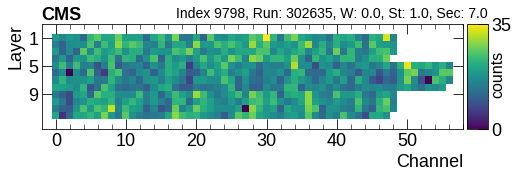

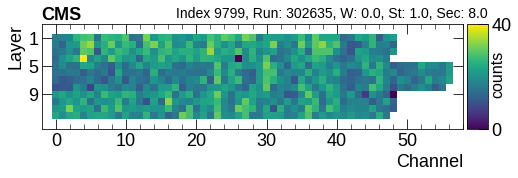

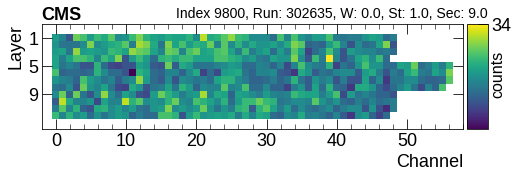

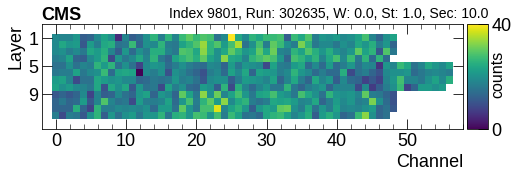

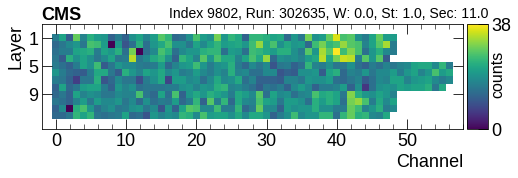

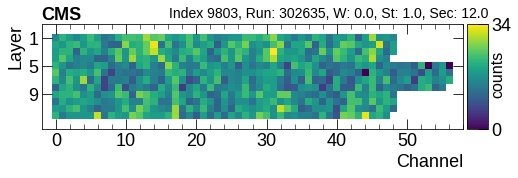

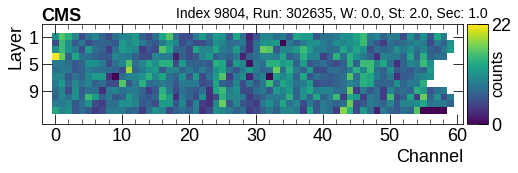

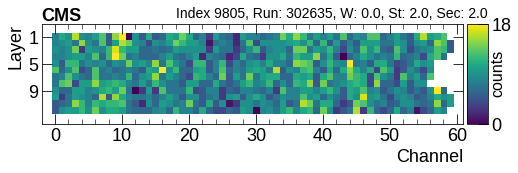

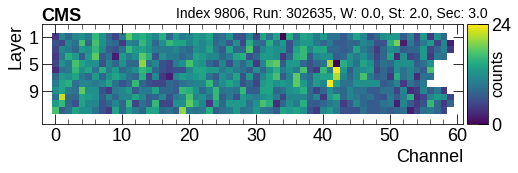

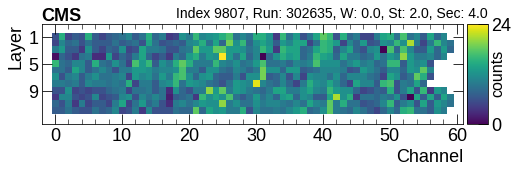

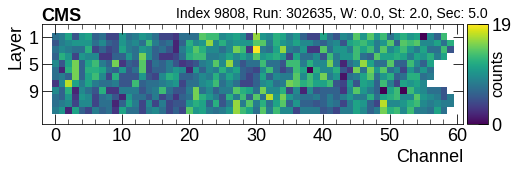

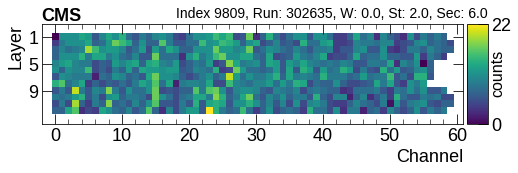

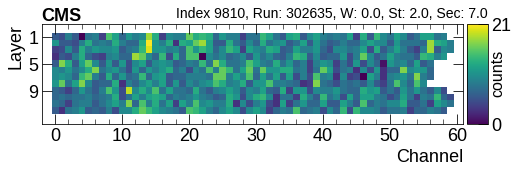

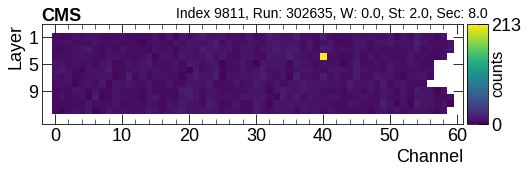

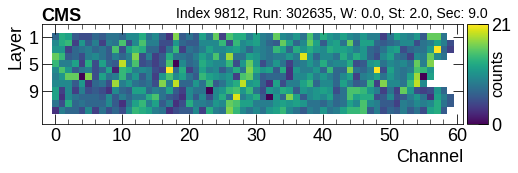

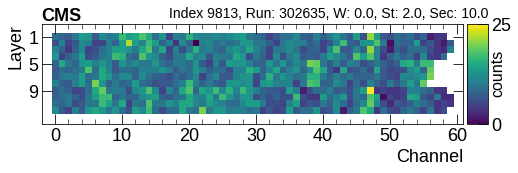

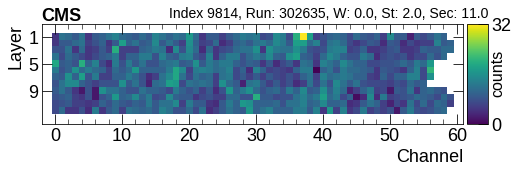

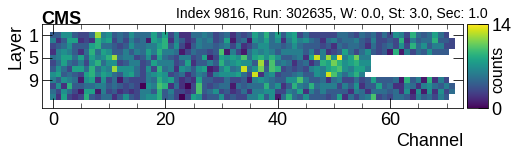

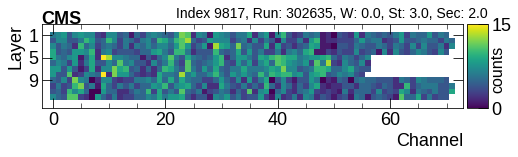

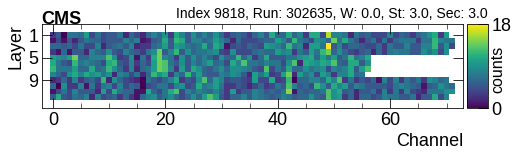

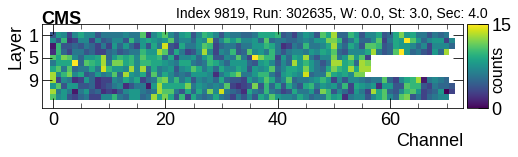

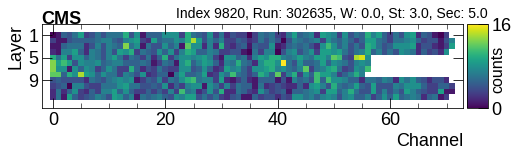

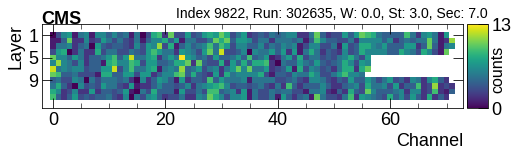

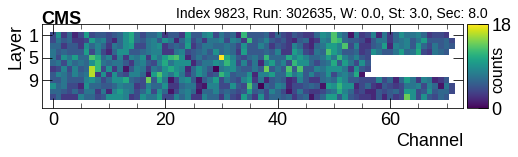

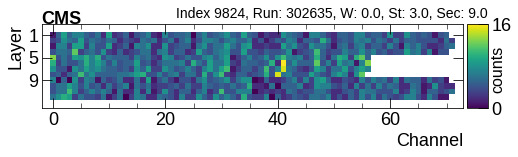

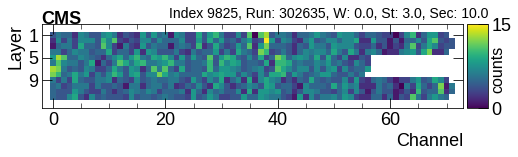

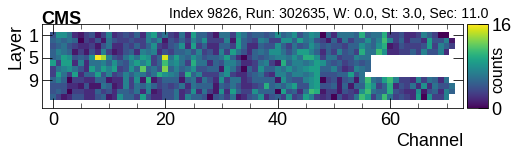

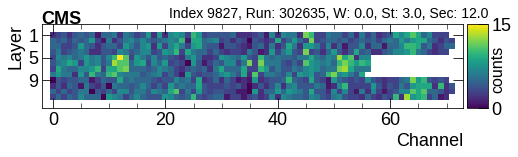

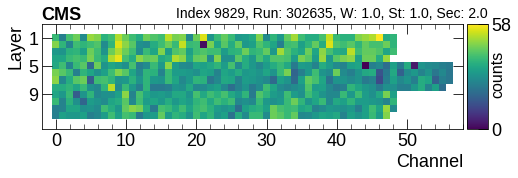

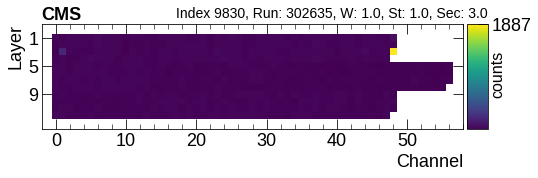

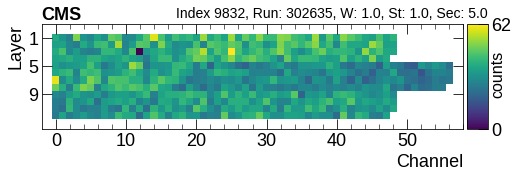

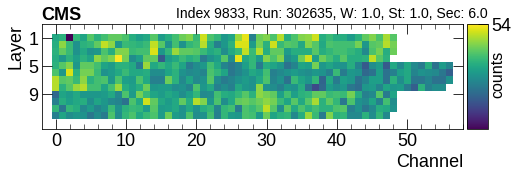

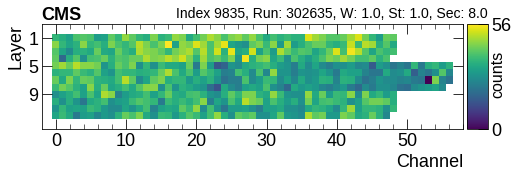

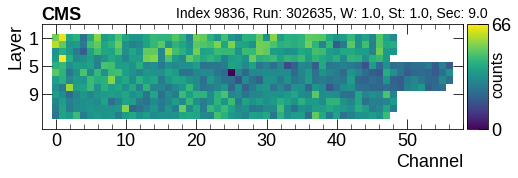

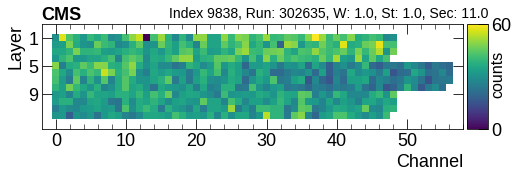

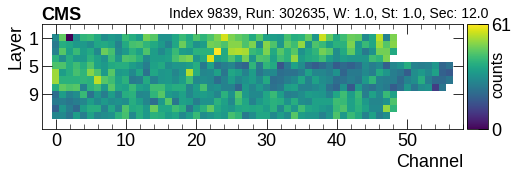

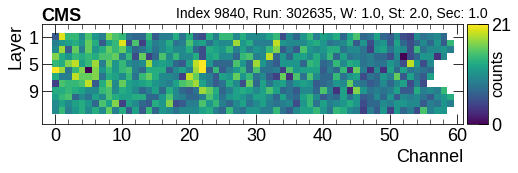

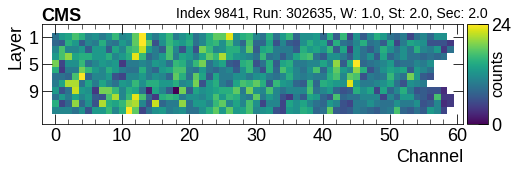

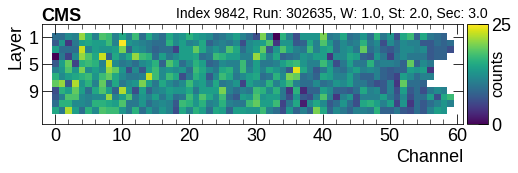

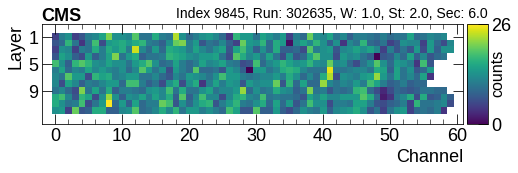

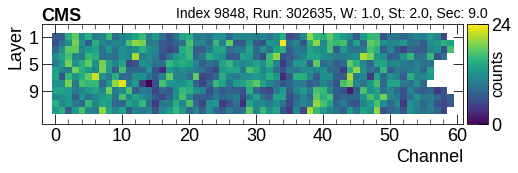

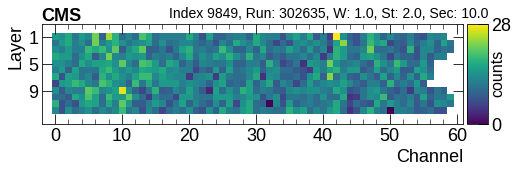

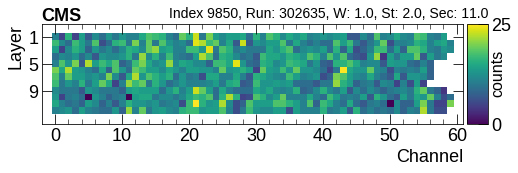

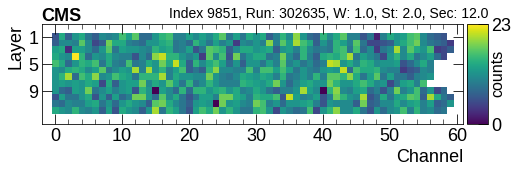

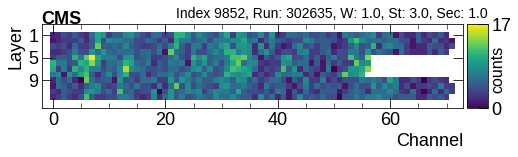

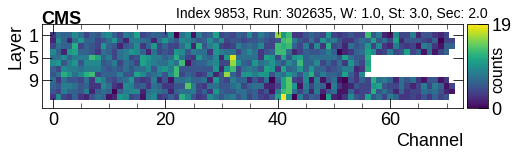

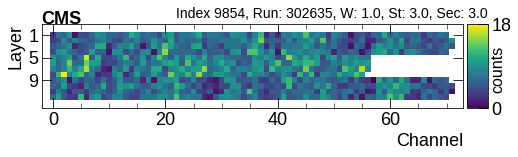

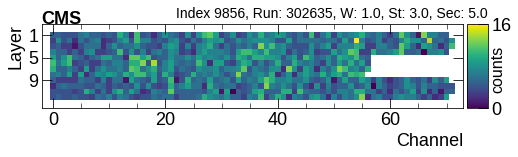

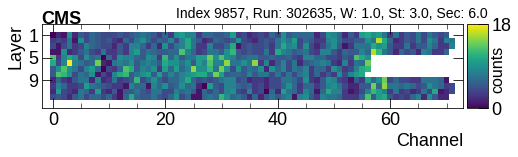

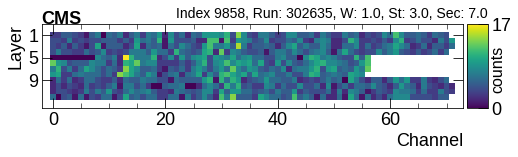

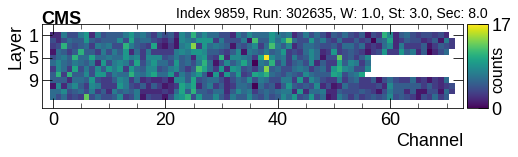

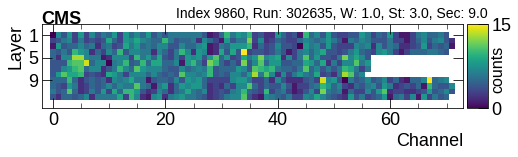

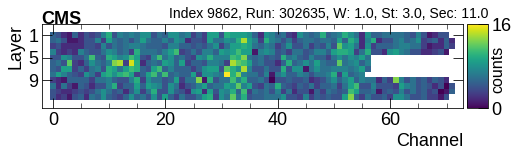

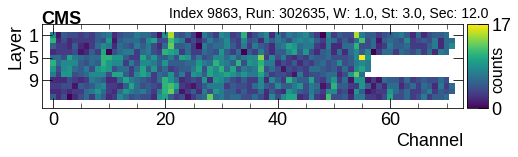

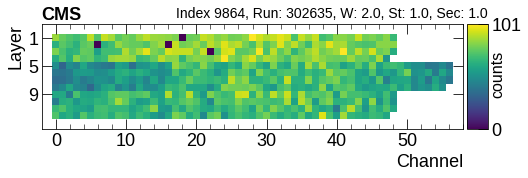

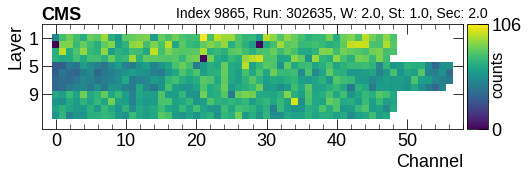

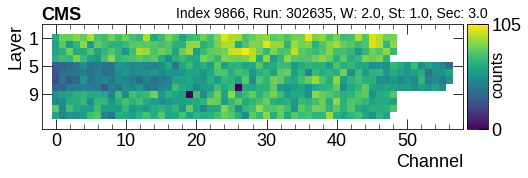

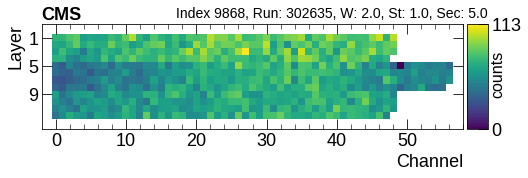

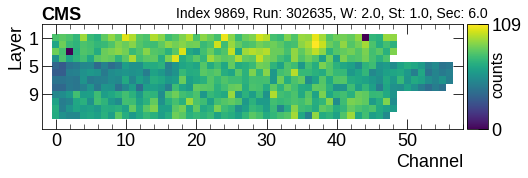

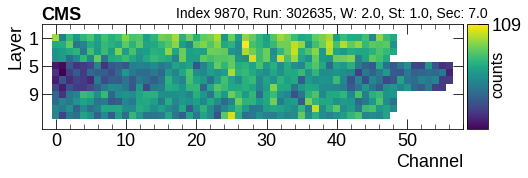

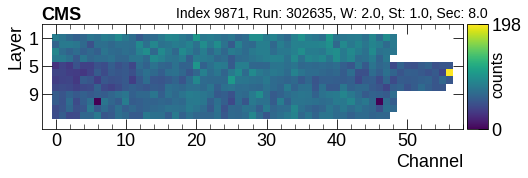

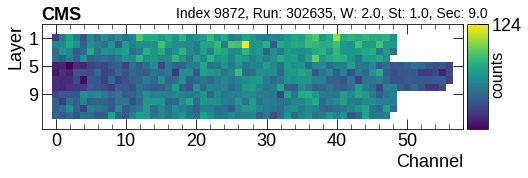

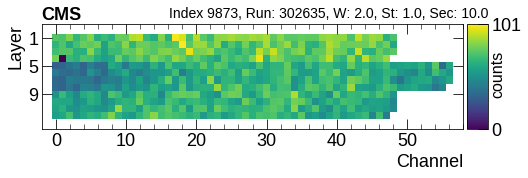

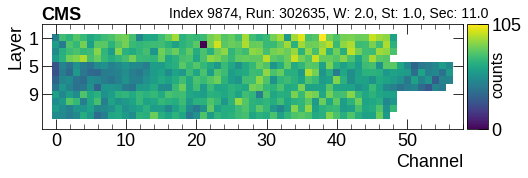

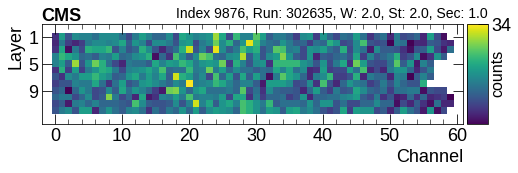

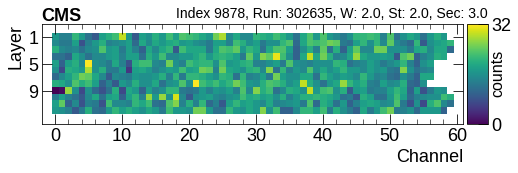

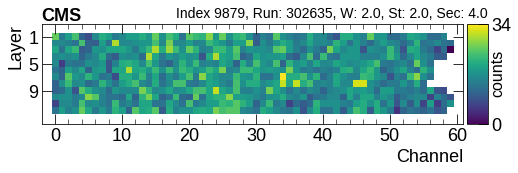

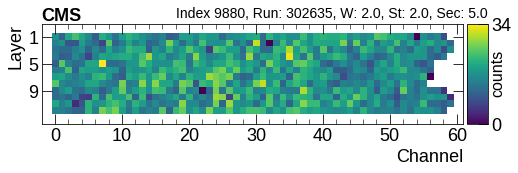

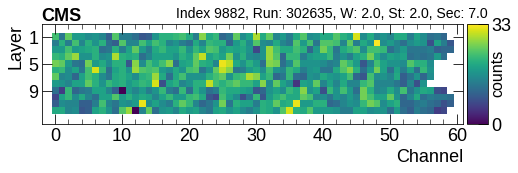

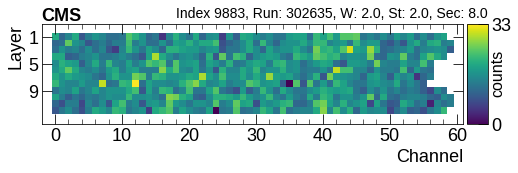

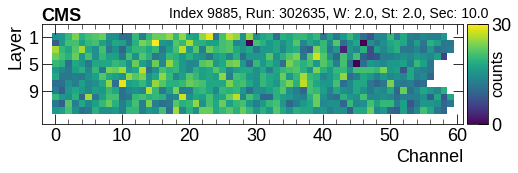

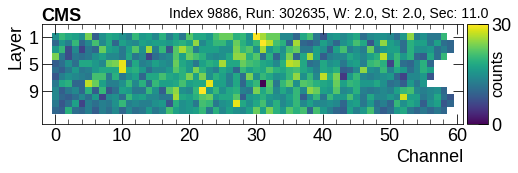

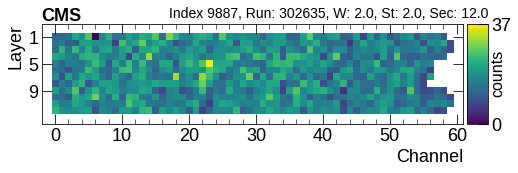

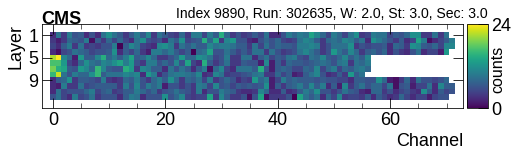

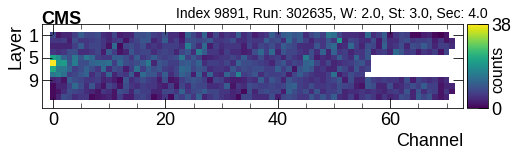

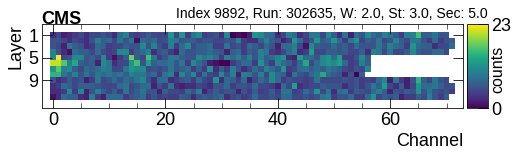

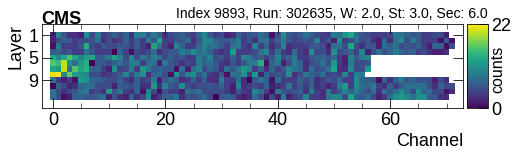

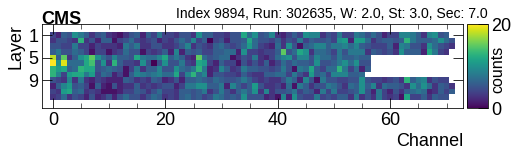

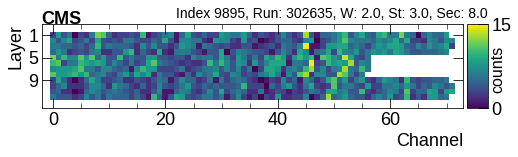

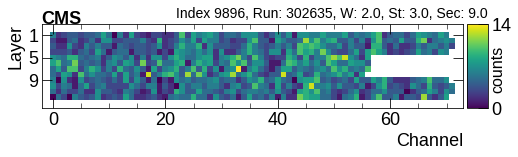

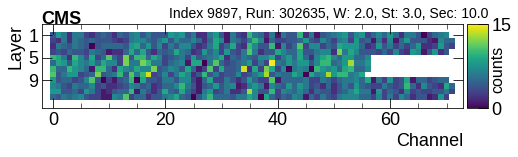

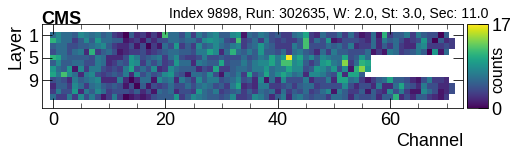

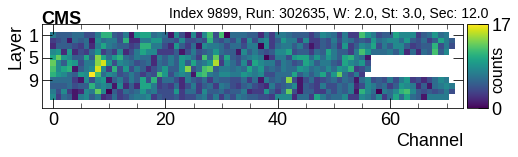

In [21]:
# Visually veryfy score (only claimed as good ones)

for i in drift_tubes_chambers[(drift_tubes_chambers.run.isin(test_run)) &
                              (drift_tubes_chambers.combined_score == -1)].index:
    show = drift_tubes_chambers.loc[i]
    plot_occupancy_hitmap(show.content_raw,
                          get_title("Index %s, " % i, show),
                          False,
                          "counts")

In [22]:
# Make corrections

indexes_to_relabel = [9767, 9804]
drift_tubes_chambers.loc[indexes_to_relabel, "combined_score"] = 1
drift_tubes_chambers.loc[indexes_to_relabel, "score"] = 1

### Production baseline

In [23]:
def production_test(content):
    """Calculate score that mirrors the test currently in production"""
    return (float(len(np.where(content == 0)[0])) / len(np.where(~np.isnan(content))[0]))

prod = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]["content_raw"].apply(production_test) > 0.1

print("Model sensitivity: %s%%" % round(100*sum(prod)/len(prod), 2))

Model sensitivity: 5.89%


### Local model baseline

In [24]:
# This reports how many chambers having a voltage problem have also a dead region

def benchmark(y_true, y_score):
    y_pred = 2*(y_score > 0) - 1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(100*float(tp)/(tp+fn))
    
print("Model sensitivity: %s percent"
      % benchmark(drift_tubes_layers[drift_tubes_layers["run"].isin(test_run)]["voltage_fault"],
                  drift_tubes_layers[drift_tubes_layers["run"].isin(test_run)]["score"]))

Model sensitivity: 6.0 percent


### Examples of voltage fault

Old test score: 0.01


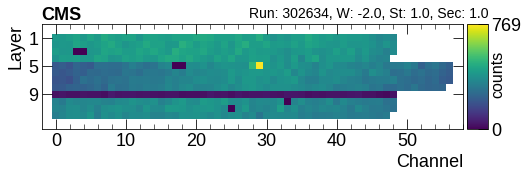

In [25]:
show = drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                            (drift_tubes_chambers["score"] == 0)].iloc[0]

print("Old test score: %s" % round(production_test(show["content_raw"]), 2))

plot_occupancy_hitmap(show.content_raw, get_title("", show), "H", "counts")

Old test score: 0.0


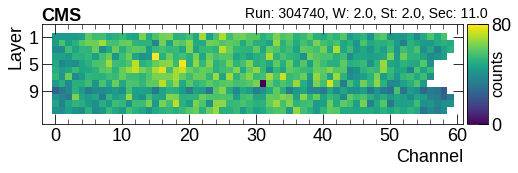

In [26]:
show = drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                            (drift_tubes_chambers["score"] == 0)].iloc[-10]

print("Old test score: %s" % round(production_test(show["content_raw"]), 2))

plot_occupancy_hitmap(show.content_raw, get_title("", show), "I", "counts")

### Benchmarking neural networks

In [27]:
# Start Keras session

sess = tf.Session()
K.set_session(sess)

In [28]:
# Generate input

train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                             (drift_tubes_chambers.score == 0)]
x_train = np.concatenate(
    train["content_scaled"].values).reshape(-1, 12, SAMPLE_SIZE, 1)
x_test = np.concatenate(
    drift_tubes_chambers["content_scaled"].values).reshape(-1, 12, SAMPLE_SIZE, 1)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

In [29]:
# Define networks

bottleneck = 20

def simple_autoencoder(sparse=None):
    _input = Input(shape=(12, 46, 1), name="Input_Image")
    x = Flatten(name="Flatten")(_input)
    x = Dense(50, kernel_regularizer=sparse)(x)
    x = PReLU()(x)
    x = Dense(bottleneck, name="encoded", kernel_regularizer=sparse)(x)
    x = PReLU()(x)
    x = Dense(50, kernel_regularizer=sparse)(x)
    x = PReLU()(x)
    x = Dense(12*46, name="Flatten2", activation="sigmoid")(x)
    decoded = Reshape((12, 46, -1), name='Reshape')(x)
    return Model(_input, decoded)

def convolutional_autoencoder():
    _input = Input(shape=(12, 46, 1), name="Input_Image")
    x = Conv2D(4, (4, 4), padding="same", name="Convolution_1")(_input)
    x = PReLU(name="Activation_1")(x)
    x = AveragePooling2D((4, 4), padding="same", name="Polling_1")(x)
    x = Flatten(name="Flatten")(x)
    x = Dense(20, name="Dense1")(x)
    x = PReLU(name="encoded")(x)
    x = Dense(144, name="Flatten2")(x)
    x = PReLU()(x)
    x = Reshape((3, 12, -1), name="Reshape")(x)
    x = UpSampling2D((4, 4))(x)
    x = Conv2D(4, (4, 4), padding="same")(x)
    x = PReLU()(x)
    decoded = Conv2D(1, (1, 3), activation="sigmoid", padding="valid")(x)
    return Model(_input, decoded)

def global_autoencoder():
    _input = Input(shape=(12, 46, 1), name="Input_Image")
    x = Flatten(name="Flatten")(_input)
    x = Dense(50)(x)
    x = PReLU()(x)
    encoded = Dense(3)(x)
    x = PReLU()(encoded)
    x = Dense(50)(x)
    x = PReLU()(x)
    x = Dense(12*46, name="Flatten2", activation="sigmoid")(x)
    decoded = Reshape((12, 46, -1), name='Reshape')(x)
    return Model(_input, encoded), Model(_input, decoded)

autoencoder_simple = simple_autoencoder()
autoencoder_sparse = simple_autoencoder(regularizers.l1(1e-5))
autoencoder_convolution = convolutional_autoencoder()
encoder_bottleneck, autoencoder_global = global_autoencoder()

print("Global Auto-encoder:")
autoencoder_global.summary()
print("Sparse Auto-encoder:")
autoencoder_sparse.summary()
print("Simple Auto-encoder:")
autoencoder_simple.summary()
print("Convolution Auto-encoder:")
autoencoder_convolution.summary()

Global Auto-encoder:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Image (InputLayer)     (None, 12, 46, 1)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 552)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                27650     
_________________________________________________________________
p_re_lu_9 (PReLU)            (None, 50)                50        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
_________________________________________________________________
p_re_lu_10 (PReLU)           (None, 3)                 3         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                

In [30]:
autoencoders = [autoencoder_simple,
                autoencoder_simple,
                autoencoder_sparse,
                autoencoder_convolution,
                autoencoder_global]

autoencoders_names = ["bottleneck",
                      "denoising",
                      "sparse",
                      "convolutional",
                      "global"]

In [31]:
# Train neural networks

for (ae, ae_name) in zip(autoencoders, autoencoders_names):
    if not LOAD_MODELS:
        
        if ae_name == "Denoising":
            train_in = x_train_noisy
        else:
            train_in = x_train

        print("Compiling the model.", end="\r")

        ae.compile(optimizer="adam", loss="mse")

        early_stopper = EarlyStopping(monitor="val_loss",
                                      patience=32,
                                      verbose=False,
                                      mode="auto")

        checkpoint_callback = ModelCheckpoint(("%s/%s.h5" % (models_directory, ae_name)),
                                              monitor="val_loss",
                                              verbose=False,
                                              save_best_only=True,
                                              mode="min")

        print("Training %s autoencoder with %s samples..." % (ae_name, len(train)), end="\r"),

        history_ae = ae.fit(train_in,
                           x_train,
                           epochs=8192,
                           validation_split=0.2,
                           batch_size=int((len(x_train)*0.75)/2),
                           shuffle=True,
                           verbose=False,
                           initial_epoch=1,
                           callbacks=[early_stopper,
                                      checkpoint_callback])
        
        with open("%s/history-%s.pkl" % (models_directory, ae_name), "wb+") as history:
            pickle.dump(history_ae.history, history)

In [32]:
# Save encoder

if not LOAD_MODELS:
    encoder_bottleneck.save("%s/global_encoder.h5" % models_directory)

bottleneck


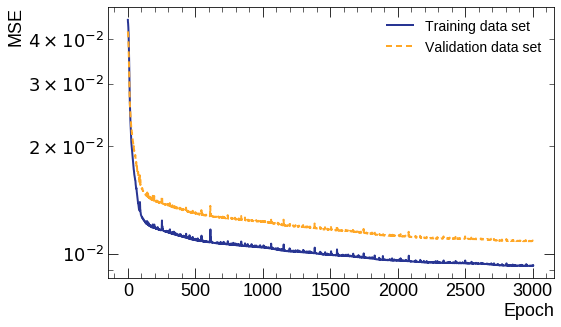

denoising


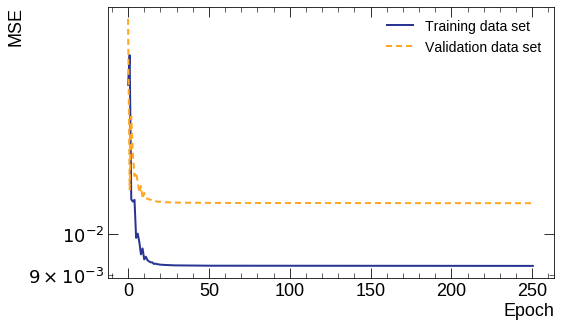

sparse


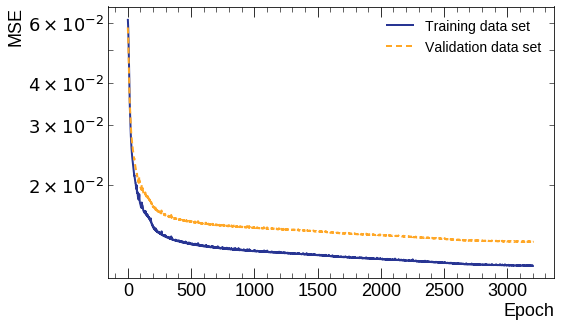

convolutional


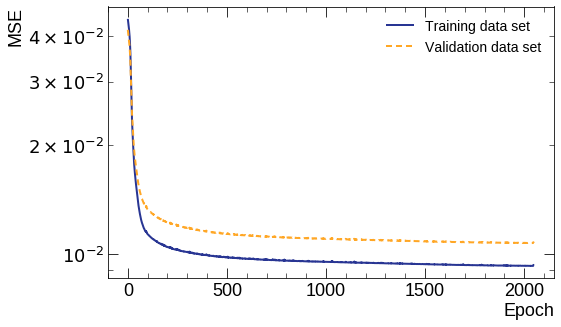

global


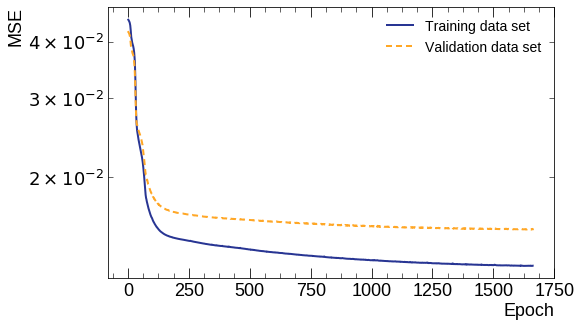

In [33]:
# Plot loss vs. epoch

def plot_loss(data):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("MSE", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    plt.yscale("log")

    plt.show();
    
for name in autoencoders_names:
    with open("%s/history-%s.pkl" % (models_directory, name), "rb") as history:
        print(name)
        plot_loss(pickle.load(history))

In [34]:
# Reload models from saved

for name in autoencoders_names:
    autoencoder = load_model(("%s/%s.h5" % (models_directory, name)))

    score = "score_%s" % name
    decoded = "decoded_%s" % name
    encoded = "encoded_%s" % name
    
    decoded_imgs = autoencoder.predict(x_test).reshape(len(drift_tubes_chambers), 12, SAMPLE_SIZE)
    mse = np.sum(np.sum((x_test.reshape(len(drift_tubes_chambers), 12, SAMPLE_SIZE) - decoded_imgs) ** 2,
                        axis = 1),
                 axis=1)
    
    drift_tubes_chambers.loc[:, score] = mse
    drift_tubes_chambers.loc[:, decoded] = pd.DataFrame(
        {decoded: decoded_imgs.tolist()})
    
    if name == "global":
        encoder_bottleneck = load_model("%s/global_encoder.h5" % models_directory)
        drift_tubes_chambers.loc[:, encoded] = pd.DataFrame(
            {encoded: encoder_bottleneck.predict(x_test).reshape(-1, 3).tolist()})

/opt/anaconda3/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### Data snooping

In [35]:
def original_vs_reconstructed(show):
    plot_occupancy_hitmap(show.content_scaled, get_title("Original, ", show), False, "a.u.")
    plot_occupancy_hitmap(show.decoded_denoising, get_title("Reconstructed, ", show), False, "a.u.")

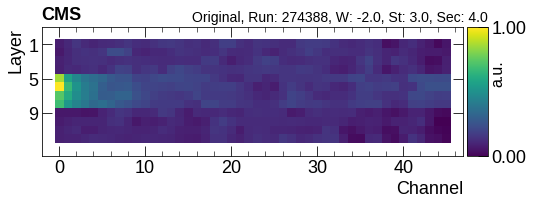

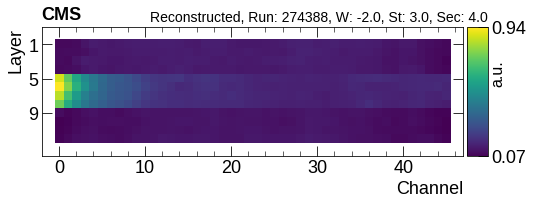

In [36]:
# The best reconstruction
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_denoising', ascending=1).iloc[0])

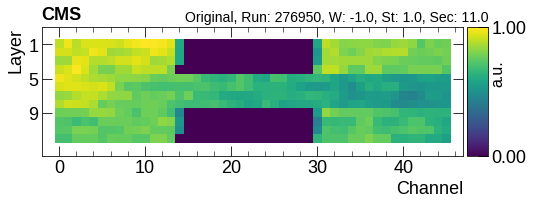

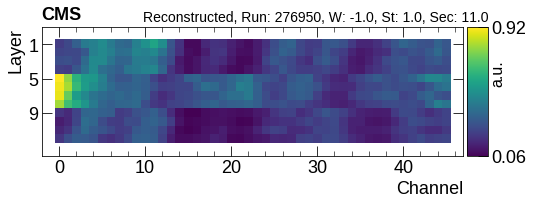

In [37]:
# The worst reconstruction
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_denoising', ascending=0).iloc[0])

#### Evaluation

In [38]:
# Define styles for plots

lines = [(color_palette["Orange"][900], line_styles[0]),
         (color_palette["Indigo"][700], line_styles[2]),
         (color_palette["Indigo"][400], line_styles[1]),
         (color_palette["Indigo"][100], line_styles[0]),
         (color_palette["Indigo"][100], line_styles[0])]

In [39]:
# ROC Curve plotting function

def get_roc_curve(test_df, models):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    test_df = test_df[(test_df["score"] == 0)]
    
    for i, (legend_label, model_score) in enumerate(models):
        fpr, tpr, _ = roc_curve(test_df["voltage_fault"], test_df[model_score])
        auc_v = round(auc(fpr, tpr), 3)
        plt.plot(fpr,
                 tpr,
                 color=lines[i][0],
                 linestyle=lines[i][1],
                 label=("%s, AUC: %s" % (legend_label, auc_v)))

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)", horizontalalignment='right', y=1.0)
    plt.xlabel("Fall-out (1-TNR)", horizontalalignment='right', x=1.0)
    plt.xlim(0, 1)
    plt.ylim(0.5, 1)
    
    fig.savefig("%s/reginal_roc.eps" % figure_export_directory, bbox_inches="tight")
    plt.show();

In [40]:
# Define test set

df_test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                               (drift_tubes_chambers["score"] == 0)].copy()
remove_incorrect_benchmarks = [9630, 9707]
df_test.drop(remove_incorrect_benchmarks, inplace=True)

In [41]:
# Calculate loss per layer

def layer_x_loss(column, layer):
    """Returns MSE of a given layer"""
    losses = []
    for sample_loss in df_test["content_scaled"] - df_test[column]:
        losses.append(np.sum(abs(sample_loss), axis=1)[layer-1])
    return losses

drift_tubes_chambers.loc[df_test.index, "score_bottleneck_9"] = pd.DataFrame(
    {"score_bottleneck_9": layer_x_loss("decoded_bottleneck", 9)}, index=df_test.index)
drift_tubes_chambers.loc[df_test.index, "score_convolution_9"] = pd.DataFrame(
    {"score_convolution_9": layer_x_loss("decoded_convolutional", 9)}, index=df_test.index)
drift_tubes_chambers.loc[df_test.index, "score_sparse_9"] = pd.DataFrame(
    {"score_sparse_9": layer_x_loss("decoded_sparse", 9)}, index=df_test.index)
drift_tubes_chambers.loc[df_test.index, "score_denoising_9"] = pd.DataFrame(
    {"score_denoising_9": layer_x_loss("decoded_denoising", 9)}, index=df_test.index)

drift_tubes_chambers.loc[df_test.index, "score_convolution_3"] = pd.DataFrame(
    {"score_convolution_3": layer_x_loss("decoded_convolutional", 3)}, index=df_test.index)

In [42]:
# Define test set

df_test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                               (drift_tubes_chambers["score"] == 0)].copy()
remove_incorrect_benchmarks = [9630, 9707]
df_test.drop(remove_incorrect_benchmarks, inplace=True)

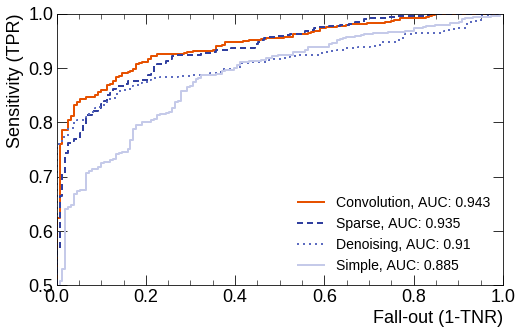

In [43]:
get_roc_curve(df_test,
              [("Convolution", "score_convolution_9"),
               ("Sparse", "score_sparse_9"),
               ("Denoising", "score_denoising_9"),
               ("Simple", "score_bottleneck_9")])

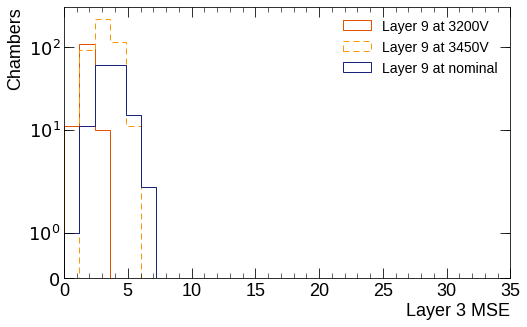

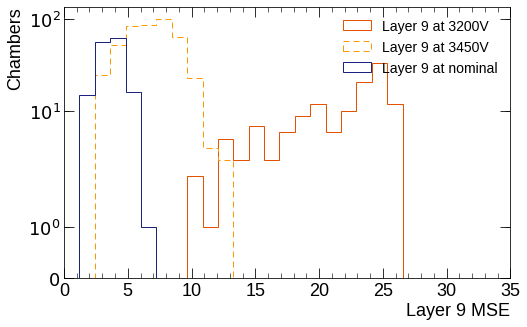

In [44]:
# Error distribution

def error_distribution(score, bins_o, x_axis, layer):
    
    binBoundaries = np.linspace(0, 35, bins_o)
    
    fig, ax1 = plt.subplots()
    
    ax1.hist(df_test[(df_test.voltage_fault == 1) & (df_test.run == 302634)][score].values,
             label = "Layer 9 at 3200V",
             ls = line_styles[0],
             facecolor = "None",
             edgecolor = color_palette["Orange"][900],
             histtype = 'step',
             bins = binBoundaries)
    
    ax1.hist(df_test[(df_test.voltage_fault == 1) & (df_test.run != 302634)][score].values,
             label = "Layer 9 at 3450V",
             ls = line_styles[2],
             facecolor = "None",
             edgecolor = color_palette["Orange"][500],
             histtype = 'step',
             bins = binBoundaries)
    
    ax1.hist(df_test[df_test.combined_score == -1][score].values,
             label = "Layer 9 at nominal",
             ls = line_styles[0],
             facecolor = "None",
             edgecolor = color_palette["Indigo"][900],
             histtype = 'step',
             bins = binBoundaries)

    ax1.set_ylabel("Chambers", horizontalalignment='right', y=1.0)
    plt.legend(frameon=False)
    plt.xlabel(x_axis, horizontalalignment='right', x=1.0)
    plt.xlim([0,35])
    plt.yscale("symlog")
    plt.subplots_adjust(hspace=0.9)
    fig.savefig("%s/regional_score_layer%s.eps" % (figure_export_directory, layer), bbox_inches="tight")
    plt.show()
    
error_distribution("score_convolution_3", 30, "Layer 3 MSE", 3)
error_distribution("score_convolution_9", 30, "Layer 9 MSE", 9)

# Global approach to Drift Tubes Digi Occupancy Anomaly Problem

In [45]:
def dimensionality_reduction(column, coloring, name, coordinates=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    if coordinates:
        evaluation = drift_tubes_chambers[(drift_tubes_chambers.wheel == coordinates[0]) &
                                          (drift_tubes_chambers.station == coordinates[1]) &
                                          (drift_tubes_chambers.sector == coordinates[2])]
    else:
        evaluation = drift_tubes_chambers[drift_tubes_chambers[column].notnull()]
        
    encoded = np.array([_ for _ in evaluation[column].values])

    plt.scatter(encoded[:, 0],
                encoded[:, 1],
                zs=encoded[:, 2],
                cmap=cmap,
                c=evaluation[coloring].values,
                #alpha=0.9,
                s=10,
                marker="o")

    if coloring == "station":
        cbar = plt.colorbar(ticks=range(1, 4))
        cbar.ax.set_yticklabels(["Station 1", "Station 2", "Station 3"])
    else:
        fig.text(0.85, 0.9, "faulty layers", rotation=90, color="black", fontsize=16)
        cbar = plt.colorbar(ticks=range(13))
        cbar.ax.set_yticklabels(range(13))
        title = ("W: %s, St: %s, Sec: %s" %
                 (coordinates[0], coordinates[1], coordinates[2]))
        plt.title(title)

    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    
    fig.savefig("%s/global_%s.eps" % (figure_export_directory, name), bbox_inches="tight")
    plt.show()

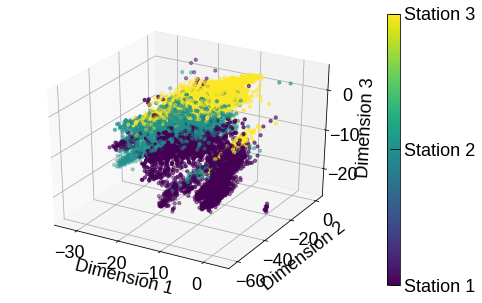

In [47]:
vmax = 2.0
cmap = matplotlib.cm.viridis
dimensionality_reduction("encoded_global", "station", "one")

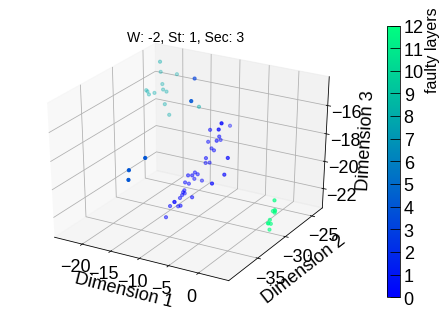

In [49]:
vmax = 1.0
cmap = matplotlib.cm.winter

dimensionality_reduction("encoded_global", "score", "two", coordinates=[-2,1,3])